In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit
import statsmodels.stats.multitest
from pycytominer import aggregate
from parse_cp_features import parse_cp_features

# Suppressing warnings for cleaner output
import warnings

warnings.filterwarnings("ignore")

In [2]:
def load_data(filepath, filters=None):
    """
    Load the data from a given filepath and apply any filters.

    Parameters:
    - filepath: str, path to the data file.
    - filters: dict, key-value pairs for filtering the data.

    Returns:
    - df: DataFrame, the loaded (and possibly filtered) data.
    """
    df = pd.read_csv(filepath)
    if filters:
        for key, value in filters.items():
            df = df[~df[key].isin(value)]
    return df

In [30]:
def code_conditions(df, column, mappings):
    """
    Encode conditions such as "deletion" and "control" into integer values.

    Parameters:
    - df: DataFrame, the data.
    - column: str, the column to modify.
    - mappings: dict, the conditions and their integer encodings.

    Returns:
    - df: DataFrame, the modified data.
    """
    for key, value in mappings.items():
        if not isinstance(value, int):
            raise ValueError("Condition mappings must be integers.")
        df.loc[df[column] == key, column] = value

    df[column] = df[column].astype(int)

    return df


def split_data(
    df, feature_columns, target_column, group_column, train_size=0.8, random_state=42
):
    """
    Split the data into training and test sets.

    Parameters:
    - df: DataFrame, the data.
    - feature_columns: list, columns to use as features.
    - target_column: str, the target variable column.
    - group_column: str, the column to group by for splitting.
    - train_size: float, proportion of the dataset to include in the train split.
    - random_state: int, seed used by the random number generator.

    Returns:
    - X_train, X_test, y_train, y_test: arrays, the split data.
    """
    if not set(feature_columns + [target_column, group_column]).issubset(df.columns):
        raise ValueError("One or more provided columns do not exist in the DataFrame.")

    X = df[feature_columns].values
    y = df[target_column].values
    gss = GroupShuffleSplit(
        n_splits=1, train_size=train_size, random_state=random_state
    )

    train_idx, test_idx = next(gss.split(X, y, df[group_column]))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    return X_train, X_test, y_train, y_test

In [19]:
def logistic_regression(X_train, y_train, X_test, y_test, feature_columns):
    """
    Perform logistic regression and return the accuracy score and feature weights.

    Parameters:
    - X_train, X_test, y_train, y_test: arrays, the training and test data.
    - feature_columns: list, names of the features.

    Returns:
    - score: float, the accuracy of the model.
    - feature_weights: DataFrame, weights of each feature.
    """

    # Initialize logistic regression model
    logisticRegr = LogisticRegression(max_iter=10000)

    # Train the model
    logisticRegr.fit(X_train, y_train)

    # Predict on the test data and calculate accuracy score
    score = logisticRegr.score(X_test, y_test)

    # Extract feature weights
    feature_weights = pd.DataFrame(
        logisticRegr.coef_[0], columns=["weight"], index=feature_columns
    ).sort_values(by="weight", ascending=False)

    return score, feature_weights

In [ ]:
def mann_whitney_u_test(df, feature_columns, condition_column, conditions):
    """
    Conduct the Mann-Whitney U-test and return p-values.

    Parameters:
    - df: DataFrame, the data.
    - feature_columns: list, columns to test.
    - condition_column: str, column with conditions to test.
    - conditions: tuple, the two conditions to test.

    Returns:
    - p_values: list, p-values for each feature.
    """
    list_p = []
    for feat in feature_columns:
        u, p = ss.mannwhitneyu(
            df.query(f"{condition_column} == {conditions[0]}")[feat],
            df.query(f"{condition_column} == {conditions[1]}")[feat],
        )
        list_p.append(p)
    _, p_values_fdr = statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05)
    return p_values_fdr

In [5]:
def visualize_channels(significant_features, parse_function):
    """
    Visualize the distribution of channels for significant features.

    Parameters:
    - significant_features: list, features found to be significant.
    - parse_function: function, used to parse features.

    Returns:
    - None, but plots the distribution.
    """
    channel_list = [parse_function(feat)["channel"] for feat in significant_features]
    df_channel = pd.DataFrame(channel_list, columns=["channel"])
    df_channel_count = df_channel.groupby("channel").size().reset_index(name="counts")
    df_channel_count["percentage"] = (
        df_channel_count["counts"] / df_channel_count["counts"].sum()
    )
    df_channel_count["sort"] = df_channel_count["channel"].str.contains("_")
    df_channel_count = df_channel_count.sort_values(
        by=["sort", "percentage"], ascending=False
    )

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x="channel", y="percentage", data=df_channel_count)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

In [31]:
# 1. Load Data
data_path = "../1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz"
filters = {"Metadata_line_ID": [23, 24, 25, 26]}
df_stem = load_data(data_path, filters=filters)

In [32]:
# 2. Pre-process Data
df_stem = code_conditions(
    df_stem, "Metadata_line_condition", {"deletion": 1, "control": 0}
)
feature_columns = [col for col in df_stem.columns if not col.startswith("Metadata")]
X_train, X_test, y_train, y_test = split_data(
    df_stem, feature_columns, "Metadata_line_condition", "Metadata_line_ID"
)

In [34]:
# 3. Analysis
# Logistic Regression

score, feature_weights = logistic_regression(
    X_train, y_train, X_test, y_test, feature_columns
)
print(f"Logistic Regression Accuracy Score: {score}")

Logistic Regression Accuracy Score: 0.8888888888888888


In [35]:
# Mann-Whitney U-test
condition_column = "Metadata_line_condition"
conditions = (1, 0)
p_values_fdr = mann_whitney_u_test(
    df_stem, feature_columns, condition_column, conditions
)

In [36]:
# Extract significant features
significant_features = [
    feature for i, feature in enumerate(feature_columns) if p_values_fdr[i] < 0.05
]
print(f"Number of Significant Features: {len(significant_features)}")

Number of Significant Features: 320


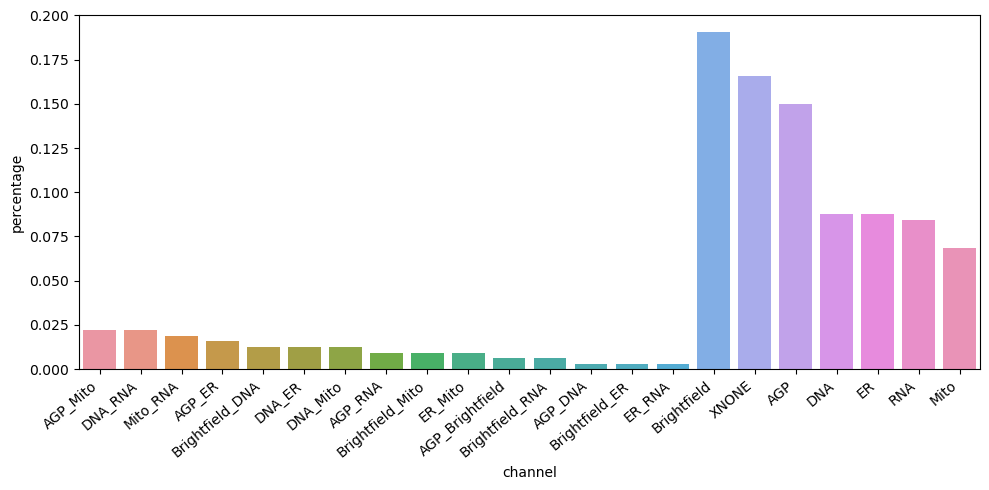

In [37]:
# 4. Visualization
visualize_channels(significant_features, parse_cp_features)